In [1]:
#### detect hardware
from google.colab import drive
drive.mount('/content/drive/')

#### check for gpu
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    print(local_device_protos)

get_available_gpus()
##################################

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10199835397960772117
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16183459840
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7188632340854346254
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [2]:
!pip install tqdm efficientnet_pytorch torchsummary torch-lr-finder

In [ ]:
!7z x /content/drive/MyDrive/logoSim/train_and_test.zip -odata\


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/logoSim/                                         1 file, 1579235829 bytes (1507 MiB)

Extracting archive: /content/drive/MyDrive/logoSim/train_and_test.zip
  2% 4096 Open               71% 122880 Open                --
Path = /content/drive/MyDrive/logoSim/train_and_test.zip
Type = zip
Physical Size = 1579235829
64-bit = +

  0%    
Would you like to replace the existing file:
  Path:     data/train_and_test/test/Accessories/24seven/12.jpg
  Size:     7604 bytes (8 KiB)
  Modified: 2020-03-03 14:59:48
with the file from archive:
  Path:     train_and_test/test/Accessories/24seven

In [3]:
root = '/content/data/train_and_test'
trainPath = root + '/train'
testPath = root + '/test'

In [4]:
import numpy as np
import glob
import os
import time
import torch
import cv2
import torchvision
import matplotlib.pyplot as plt
import tqdm.notebook as tq

from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split
from torchsummary import summary
from torch_lr_finder import LRFinder
from efficientnet_pytorch import EfficientNet

In [5]:
####VARS
batch_size= 32
H,W = 224,224

In [6]:
print(trainPath)
print(testPath)

/content/data/train_and_test/train
/content/data/train_and_test/test


In [7]:
fileList = glob.glob(trainPath + '/**/*.jpg', recursive=True)[0:10000] + glob.glob(testPath + '/**/*.jpg', recursive=True)[0:10000]
print(len(fileList))

20000


In [8]:
class LogoDataset(Dataset):

    def __init__(self, fileList, transform=None):
        self.fileList = fileList
        self.transform = transform

    def __len__(self):
        return len(self.fileList)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
          idx = idx.tolist()

        img_name = self.fileList[idx]
        label = self.fileList[idx].split('/')[-2]
        image = Image.open(img_name).convert("RGB")

        if self.transform is not None:
          image = self.transform(image)

        return image, img_name

In [9]:
transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((H,W)),
        torchvision.transforms.ToTensor(),
])

In [10]:
dataset = LogoDataset(fileList, transform=transform)
loader = DataLoader(dataset, batch_size=batch_size, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


AssertionError: ignored

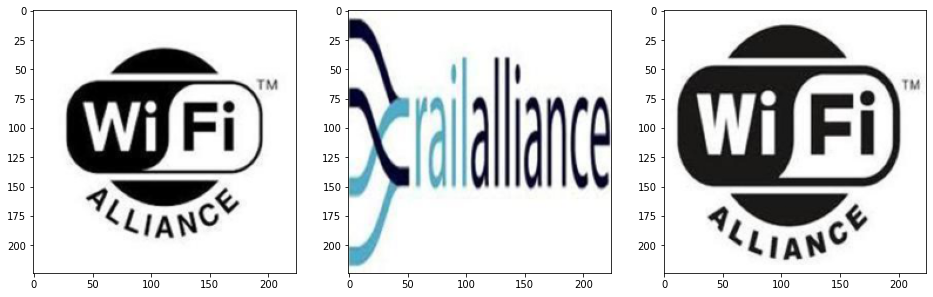

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 16))
for x,label in loader:
  axes[0].imshow(x[0].permute(1,2,0))
  axes[1].imshow(x[1].permute(1,2,0))
  axes[2].imshow(x[2].permute(1,2,0))
  assert 0

In [12]:
import torchvision.models as models

class WrapperVgg16(torch.nn.Module):
    def __init__(self):
        super(WrapperVgg16, self).__init__()
        features = models.vgg16(pretrained = True).features
        self.features = torch.nn.Sequential(features)
        self.maxPool2d = torch.nn.MaxPool2d(7,7)
        
    def forward(self, x):
        x = self.features(x)
        x = self.maxPool2d(x)
        return x.view(x.size()[0], 512)

class WrapperDensenet161(torch.nn.Module):
    def __init__(self):
        super(WrapperDensenet161, self).__init__()
        features = list(models.densenet161(pretrained = True).children())[:-1]
        self.features = torch.nn.Sequential(*features)
        self.maxPool2d = torch.nn.MaxPool2d(7,7)
        
    def forward(self, x):
        x = self.features(x)
        x = self.maxPool2d(x)
        return x.view(x.size()[0], 2208)

class WrapperResnext50(torch.nn.Module):
    def __init__(self):
        super(WrapperResnext50, self).__init__()
        features = list(models.resnext50_32x4d(pretrained = True).children())[:-1]
        self.features = torch.nn.Sequential(*features)
        self.features.eval()
        
    def forward(self, x):
        x = self.features(x)
        return x.view(x.size()[0], 2048)

class WrapperMobilenet(torch.nn.Module):
    def __init__(self):
        super(WrapperMobilenet, self).__init__()
        features = list(models.mobilenet_v3_large(pretrained = True).children())[:-1]
        self.features = torch.nn.Sequential(*features)
        self.features.eval()
        
    def forward(self, x):
        x = self.features(x)
        return x.view(x.size()[0], 960)

pretrainedModels = {
          'vgg16': WrapperVgg16,
          'densenet161': WrapperDensenet161,
          'resnext50': WrapperResnext50,
          'mobilenet': WrapperMobilenet,
}

In [13]:
from sklearn.decomposition import PCA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


allModels = []


for modelName in pretrainedModels.keys():
  model = pretrainedModels[modelName]().to(device)
  model.eval()

  pca = PCA(n_components=50)
  featureList = []
  imgPaths = []

  for i, (x, imgPath) in enumerate(tq.tqdm(loader)):
    x = x.to(device)
    features = model(x)
    features = features.cpu().detach().numpy()
    featureList.extend(features)
    imgPaths.extend(imgPath)

  featureList = np.array(list(featureList))
  featureList = pca.fit_transform(featureList)
  allModels.append([featureList, imgPaths])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


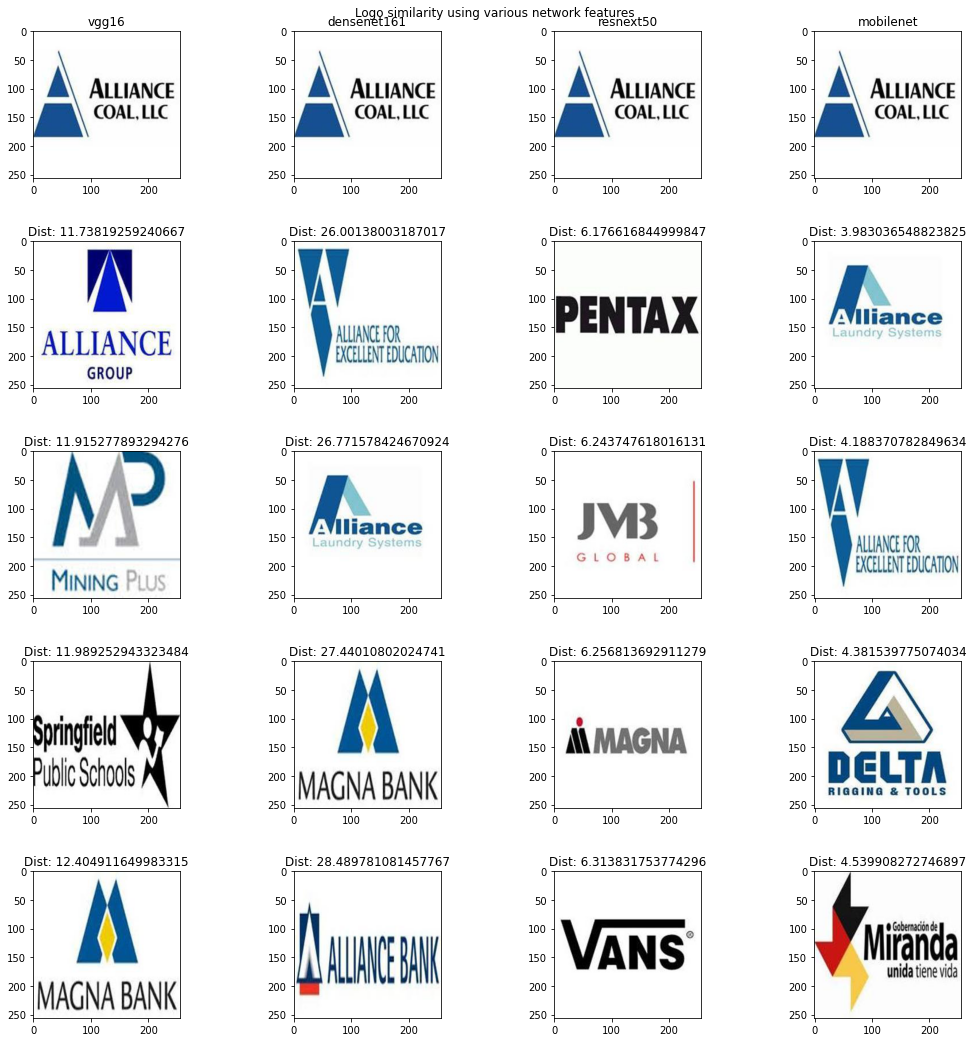

In [20]:
from sklearn.neighbors import NearestNeighbors

fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(15,15))
fig.suptitle('Logo similarity using various network features')

randIdx = np.random.randint(0, len(loader))

for idx, (x,y) in enumerate(allModels):
  
  nnEstimator = NearestNeighbors(n_neighbors=100).fit(x)
  randIdxFeature = x[randIdx].squeeze()
  distances, neighboursIdx = nnEstimator.kneighbors([randIdxFeature], 5, return_distance=True)
  baseImg = Image.open(y[randIdx]).convert("RGB")

  axs[0,idx].imshow(baseImg)
  axs[0,idx].set_title(list(pretrainedModels.keys())[idx])

  for n in range(1,5):
    dist = distances[0][n]
    nIdx = neighboursIdx[0][n]

    neighbourImg = Image.open(y[nIdx]).convert("RGB")
    axs[n,idx].imshow(neighbourImg)
    axs[n,idx].set_title('Dist: ' + str(dist))

fig. tight_layout(pad=3.0)